In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')

In [2]:
output_file = rf"./data/20251013_chi_0p37_time_domain_L_12_absorbers_width_0p2_1.h5"

data = (read_hdf5_as_dict(output_file))["simulation_data"]
samples = (read_hdf5_as_dict(output_file))["samples"]

In [3]:
import scipy.integrate
def calculate_IPR(intensity_array,x1):
    values = intensity_array
    integral_1 = scipy.integrate.simpson(values**2, x=x1, axis=0)
    integral_2 = scipy.integrate.simpson(values, x=x1,axis=0)**2

    return integral_2/integral_1

def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array

    # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return sigma

def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
flux_data_mean = [np.array([data["0.37"][nu][str(sample)]["flux"] for sample in samples]) for nu in data["0.37"].keys()]
intensity_data = [np.array([data["0.37"][nu][str(sample)]["intensity"] for sample in samples]) for nu in data["0.37"].keys()]

C:\Users\HernandF\AppData\Local\Temp\ipykernel_8012\330014983.py:28: RuntimeWarning: invalid value encountered in divide
  intensity_normalized = intensity_values/max_values_time_step
C:\Users\HernandF\AppData\Local\Temp\ipykernel_8012\3797759063.py:17: RuntimeWarning: invalid value encountered in divide
  mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_8012\3797759063.py:18: RuntimeWarning: invalid value encountered in divide
  mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_8012\330014983.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to leave space for the colorbar


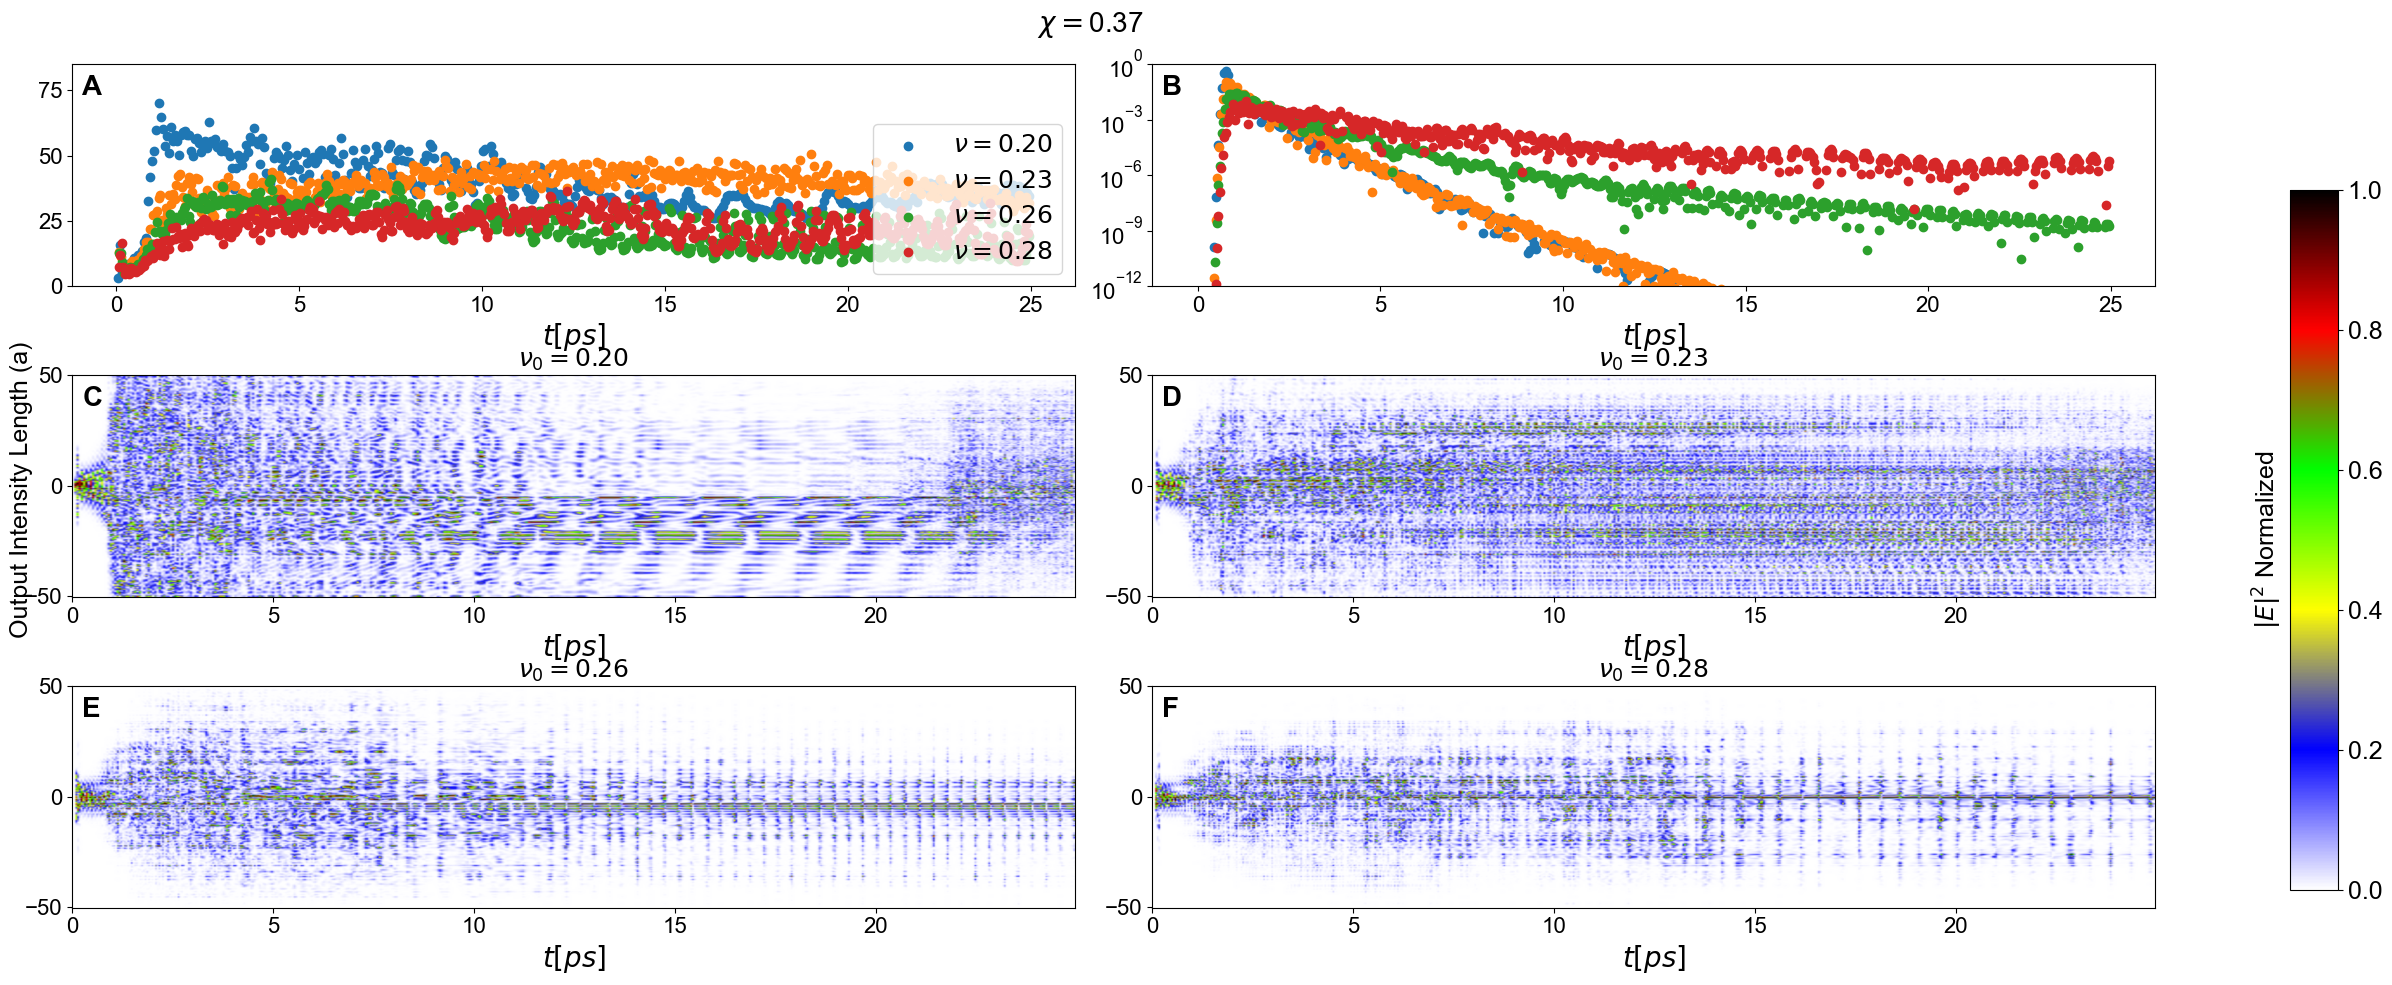

In [17]:
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
# Create a custom colormap
colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(24,10))
flatten_ax = ax.flatten()
for i, nu in enumerate(data["0.37"].keys()):
    flux = np.mean(flux_data_mean[i],axis=0)
    max_flux_index = np.argmax(flux)
    time = data["0.37"][nu]["0.0"]["time_flux"]*1e12
    time_intensity = data["0.37"][nu]["0.0"]["time_intensity"]*1e12
    x_values = data["0.37"][nu]["x"]
    y_values = data["0.37"][nu]["y"]
    index_exit = np.argmin(np.abs(y_values - 6))
    intensity_average = np.mean(intensity_data[i],axis=(0))
    intensity_values = np.copy((intensity_average[:,index_exit,:].squeeze()))
    # intensity_values[intensity_values/np.max(intensity_values)<=1e-9]=0
    max_values_time_step = (np.max(intensity_values,axis=0))
    intensity_normalized = intensity_values/max_values_time_step
    intensity_normalized[np.isnan(intensity_normalized)] = 0
    spreading = 2*calculate_sigma(intensity_normalized,x1=x_values-np.min(x_values))
    im =  flatten_ax[i+2].imshow(intensity_normalized,vmin = 0, vmax = 1, # norm=LogNorm(vmin=np.min(intensity_normalized), vmax=np.max(intensity_normalized)),
                     extent =[np.min(time),np.max(time),np.min(x_values),np.max(x_values)], 
                         origin ='lower', cmap=cmap,aspect='auto', interpolation="gaussian")
    
    flatten_ax[0].scatter(time_intensity,spreading,label=rf"$\nu={float(nu):.2f}$")
    flatten_ax[1].scatter(time,flux,label=rf"$\nu={float(nu):.2f}$")
    flatten_ax[i+2].set_title(rf"$\nu_0  = {float(nu):.2f}$",fontsize=18)
    flatten_ax[i+2].tick_params(which='major', labelsize=16)

for k,item in enumerate(flatten_ax):
    flatten_ax[k].set_xlabel(r'$t[ps]$', fontsize=20)
    flatten_ax[k].tick_params(which='major', labelsize=16)
    subplot_label = chr(65 + k)  # chr(65) = 'A', chr(66) = 'B', etc.
    flatten_ax[k].text(0.01, 0.95, subplot_label, transform=flatten_ax[k].transAxes,fontsize=20, fontweight='bold', va='top', ha='left')


flatten_ax[0].legend(fontsize=18, loc=4)
flatten_ax[0].set_ylim(0,85)


flatten_ax[1].set_yscale("log")
flatten_ax[1].set_ylim(1e-12,1)

fig.text(0.0, 0.5, 'Output Intensity Length (a)', va='center', rotation='vertical', fontsize=18)


cbar_ax = fig.add_axes([0.95, 0.10, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, ax=ax,cax=cbar_ax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(rf"$|E|^2$ Normalized", fontsize=18)
cbar.ax.yaxis.set_label_position('left')
fig.suptitle(rf"$\chi=${0.37}", fontsize=20, x=0.45)
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to leave space for the colorbar
plt.subplots_adjust(hspace=0.4)  # Increase space between rows (hspace) and columns (wspace)
plt.show()